In [2]:
import pandas as pd
import numpy as np
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import yaml
from matplotlib import rc
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 300

rc('font',**{'family':'sans-serif','serif':['Arial'], 'size':14})
rc('text', usetex=True)

In [3]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [28]:
dct, dct_err = {}, {}
dft = {}
for ab in [ 'CB6', 'CoV555', 'REGN10987', 'S309']:
    dft[ab] = pd.read_csv(f"../../../omicron/Titeseq/results/Kds/cleaned_Kds_RBD_{ab}_proper.tsv",
                 dtype={"geno":"str"}, sep=",")
    dft[ab].log10Kd = dft[ab].log10Kd.apply(lambda x: 6 if pd.isna(x) else x)

df = pd.concat([dft[ab] for ab in dft], keys=[ab for ab in dft], axis=1)
 

['i', 'j', 'pinned']
CB6 r2 0.888431269260045
CB6 acc 0.9776611328125

['e', 'v', 'pinned']
CoV555 r2 0.9168624475869729
CoV555 acc 0.868255615234375

['g', 'h', 'pinned']
REGN10987 r2 0.6474893135371804
REGN10987 acc 0.88824462890625

['c', 'd', 'pinned']
S309 r2 0.6860499762887622
S309 acc 0.99493408203125



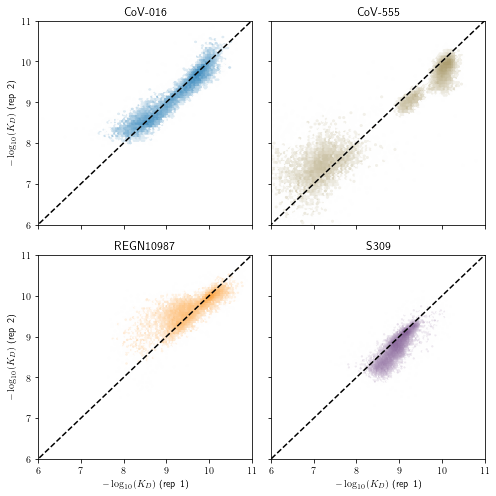

In [33]:
from sklearn.metrics import r2_score
name_ab = {'CB6': 'CoV-016', 'CoV555': 'CoV-555', 'REGN10987': 'REGN10987', 'S309': 'S309'}
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
for (ab, ax, color) in zip(['CB6', 'CoV555', 'REGN10987', 'S309'], axes.flatten(), 
                                    ['#3989BD', '#AB9C6D', '#FDA542', '#876399']):
    rep = [a.split("_")[1] for a in dft[ab].keys() if a.startswith("log10Kd_")]
    print(rep)
    for r in rep:
        dft[ab][f"log10Kd_{r}"] = dft[ab][f"log10Kd_{r}"].apply(lambda x: 6 if pd.isna(x) else x)
    
    ax.plot([5, 12], [5, 12], c='k', ls='dashed')
    ax.hexbin(
        x=dft[ab][f'log10Kd_{rep[0]}'][(dft[ab][f'log10Kd_{rep[0]}'] > 6) & (dft[ab][f'log10Kd_{rep[1]}'] > 6)],
        y=dft[ab][f'log10Kd_{rep[1]}'][(dft[ab][f'log10Kd_{rep[0]}'] > 6) & (dft[ab][f'log10Kd_{rep[1]}'] > 6)], 
        cmap=get_continuous_cmap(['#FFFFFF', color]), bins='log')
    
    ax.set_xlim((6, 11))
    ax.set_ylim((6, 11))
    
    r2 = (dft[ab][(dft[ab][f'log10Kd_{rep[0]}'] > 6) 
                    & (dft[ab][f'log10Kd_{rep[1]}'] > 6)]\
          [[f'log10Kd_{rep[0]}', f'log10Kd_{rep[1]}']].corr()**2).to_numpy()[0, 1]
    print(ab, "r2",  r2)
    dft[ab]["non-binding_rep0"] = dft[ab][f'log10Kd_{rep[0]}'] == 6
    dft[ab]["non-binding_rep1"] = dft[ab][f'log10Kd_{rep[1]}'] == 6
    acc = (~(dft[ab]["non-binding_rep0"]^dft[ab]["non-binding_rep1"])).sum()/len(dft[ab])
    
    print(ab, "acc", acc)
    print()
    

    ax.set_title(name_ab[ab])
axes[1,1].set_xlabel(r"$-\log_{10}(K_D)$ (rep 1)")
axes[1,0].set_xlabel(r"$-\log_{10}(K_D)$ (rep 1)")
axes[1,0].set_ylabel(r"$-\log_{10}(K_D)$ (rep 2)")
axes[0,0].set_ylabel(r"$-\log_{10}(K_D)$ (rep 2)")
plt.tight_layout()

plt.savefig("comparison_replicate.pdf")

In [24]:
~(True^True)

-1

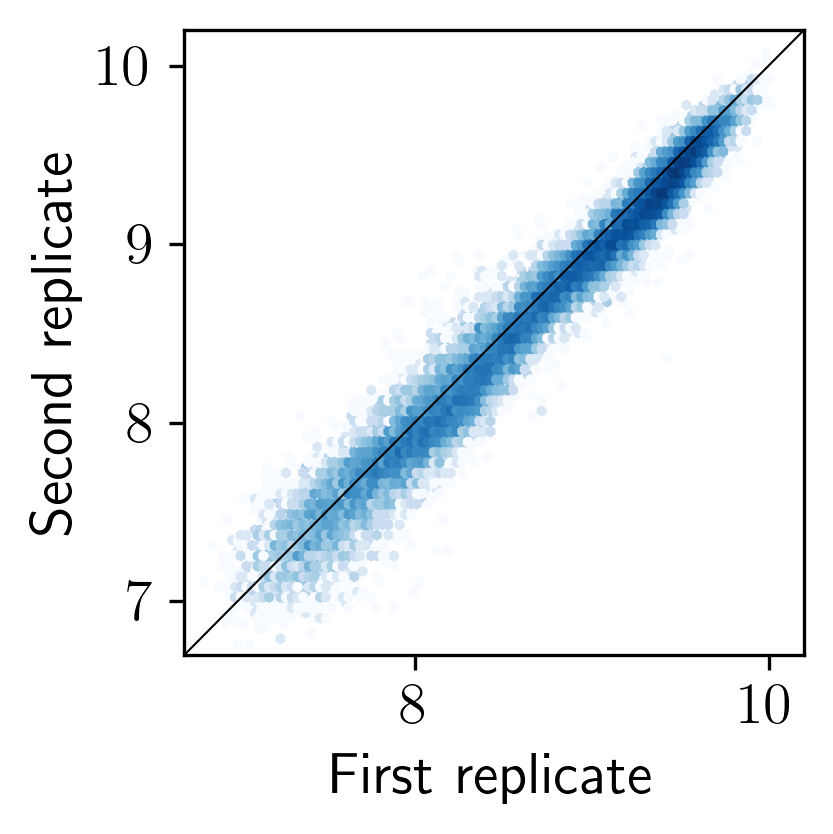

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.hexbin(x=df["log10Kd_a"], y=df["log10Kd_b"],
                  bins='log', cmap="Blues")
ax.plot([6, 11], [6, 11], color="k", lw=0.5)
ax.set_xlim((6.7, 10.2))
ax.set_ylim((6.7, 10.2))
ax.set_ylabel("Second replicate")
ax.set_xlabel("First replicate")
plt.tight_layout()

plt.savefig("../Figures/SI_QC_A.png", dpi=600)

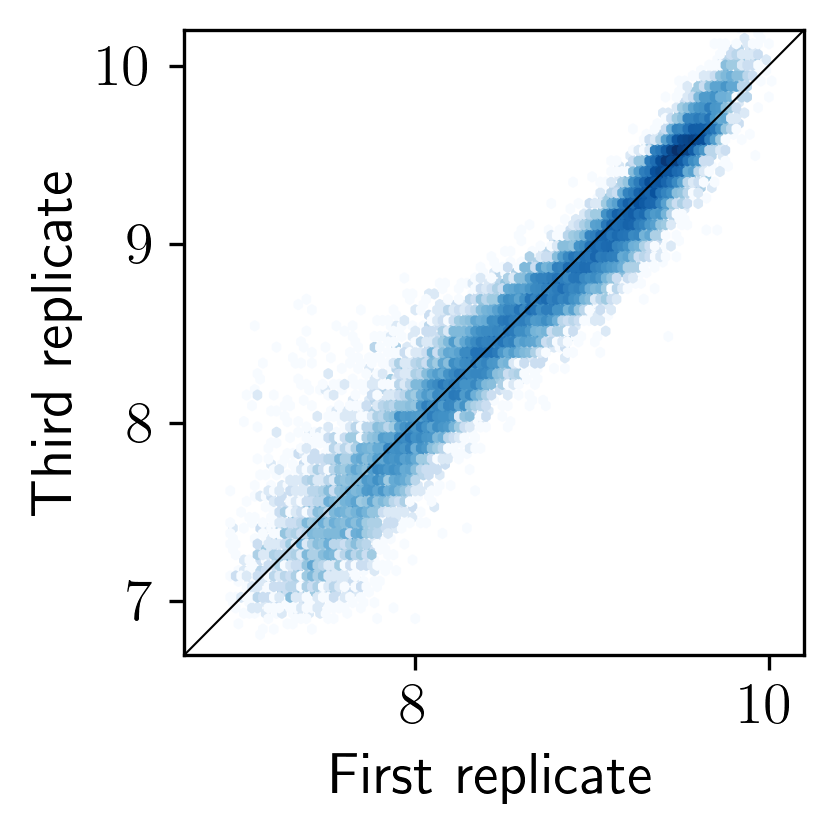

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.hexbin(x=df["log10Kd_a"], y=df["log10Kd_x"],
                  bins='log', cmap="Blues")
ax.plot([6, 11], [6, 11], color="k", lw=0.5)
ax.set_xlim((6.7, 10.2))
ax.set_ylim((6.7, 10.2))
ax.set_ylabel("Third replicate")
ax.set_xlabel("First replicate")
plt.tight_layout()
plt.savefig("../Figures/SI_QC_B.png", dpi=600)

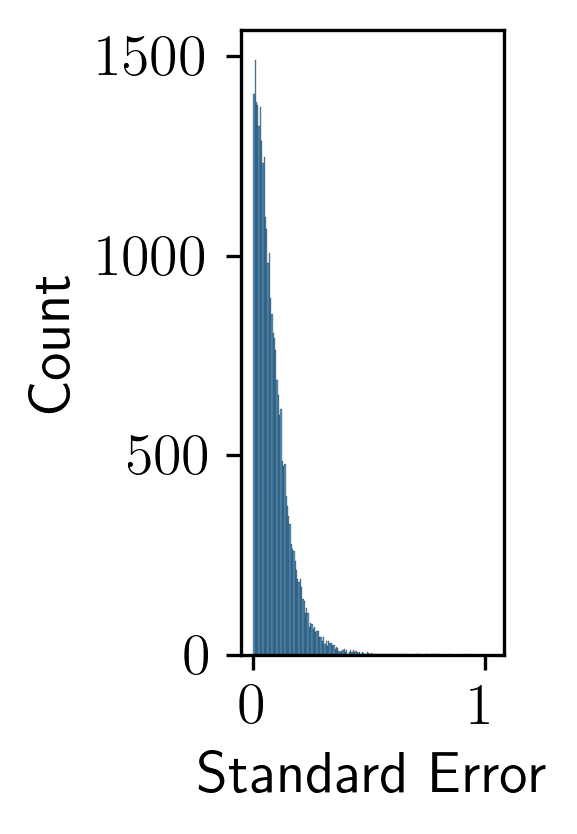

In [18]:
fig, ax = plt.subplots(figsize=(2, 3))
df["Standard Error"] = np.abs(df["log10Kd_a"] - df["log10Kd_x"])/ np.sqrt(2)
sns.histplot(df["Standard Error"])
plt.tight_layout()
plt.savefig("../Figures/SI_QC_C.png", dpi=600)

In [6]:
import scipy.stats

dfst = df.dropna(subset=["log10Kd_a", "log10Kd_x"])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfst["log10Kd_a"], dfst["log10Kd_x"])
print(r_value**2)

0.9470690579975944


In [19]:
np.nanmean(np.std(df[["log10Kd_a", "log10Kd_b", "log10Kd_x"]].to_numpy(),axis=1)/np.sqrt(3))

0.04525625560551127

In [3]:
geno = df[df.geno == '000010000000000'].iloc[0]

for x 
geno.mean_log10PE0_a


,geno,log10Kd_a,A_a,B_a,r2_a,sigma_a,mean_log10PE0_a,mean_log10PE1_a,mean_log10PE2_a,mean_log10PE3_a,...,std_log10PE5_x,std_log10PE6_x,std_log10PE7_x,std_log10PE8_x,std_log10PE9_x,std_log10PE10_x,log10Kd,err_log10Kd,mean_sigma,log10Kd_pinned
0,000000000000000,8.937612,40878.650157,148.646672,0.997343,0.413134,2.180725,4.571571,4.544330,4.630145,...,0.229122,0.310533,0.179323,0.237888,0.178754,0.226040,9.033694,0.049984,0.269023,9.033694
1,000000000000001,8.062518,50001.628987,155.742680,0.994712,0.576461,2.180161,4.536310,4.662021,4.462558,...,0.252491,0.339858,0.173390,0.262199,0.188591,0.218713,8.128408,0.152858,0.499747,8.128408
2,000000000000010,9.298267,43788.650893,137.018834,0.992158,0.403840,2.180161,4.663049,4.678946,4.633379,...,0.244940,0.375437,0.188121,0.269217,0.177106,0.246679,9.231545,0.039869,0.325845,9.231545
3,000000000000011,9.099356,40299.391179,138.861786,0.993918,0.415299,2.181001,4.570451,4.610790,4.545678,...,0.245124,0.353132,0.192290,0.235103,0.185128,0.237882,9.014345,0.061809,0.324836,9.014345
4,000000000000100,8.806448,44447.356686,144.163585,0.996186,0.291892,2.180556,4.608830,4.627035,4.567587,...,0.220619,0.284450,0.155253,0.209652,0.175637,0.211612,8.779812,0.020136,0.256620,8.779812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,111111111111011,8.755775,17687.937688,151.506643,0.995430,0.314487,2.181108,4.264327,4.295655,4.065471,...,0.388707,0.334989,0.304818,0.232856,0.225689,0.221250,8.718540,0.035787,0.315141,8.718540
32764,111111111111100,8.145813,16677.710924,159.554328,0.996055,0.416909,2.180683,4.156342,4.125937,4.057855,...,0.356579,0.287920,0.259975,0.252302,0.256410,0.294670,8.146253,0.072282,0.430764,8.146253
32765,111111111111101,7.986631,18680.177956,162.367659,0.991955,0.475599,2.180161,4.233834,4.150958,3.945768,...,0.404055,0.318600,0.291917,0.214000,0.261239,0.395547,8.101253,0.057510,0.453812,8.101253
32766,111111111111110,9.667558,18528.420467,124.712900,0.989554,0.433028,2.182593,4.269382,4.248127,4.389339,...,0.566021,0.541420,0.476015,0.449650,0.527761,0.282772,9.679073,0.070652,0.426507,9.679073
